# How to add breakpoints

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#human-in-the-loop). [Breakpoints](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) are a common HIL interaction pattern, allowing the graph to stop at specific steps and seek human approval before proceeding (e.g., for sensitive actions). 

Breakpoints are built on top of LangGraph [checkpoints](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), which save the graph's state after each node execution. Checkpoints are saved in [threads](https://langchain-ai.github.io/langgraph/concepts/low_level/#threads) that preserve graph state and can be accessed after a graph has finished execution. This allows for graph execution to pause at specific points, await human approval, and then resume execution from the last checkpoint.

![](./img/approval.png)

## Setup

First we need to install the packages required

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

Next, we need to set API keys for Anthropic (the LLM we will use)

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Simple Usage

Let's look at very basic usage of this.

Below, we do two things:

1) We specify the [breakpoint](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) using `interrupt_before` the specified step.

2) We set up a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer) to save the state of the graph.

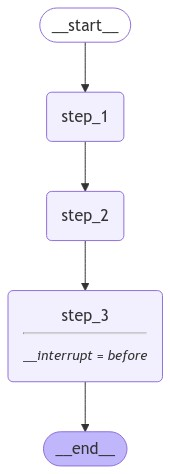

In [1]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["step_3"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We create a [thread ID](https://langchain-ai.github.io/langgraph/concepts/low_level/#threads) for the checkpointer.

We run until step 3, as defined with `interrupt_before`. 

After the user input / approval, [we resume execution](https://langchain-ai.github.io/langgraph/concepts/low_level/#breakpoints) by invoking the graph with `None`. 

In [7]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

try:
    user_approval = input("Do you want to go to Step 3? (yes/no): ")
except:
    user_approval = "yes"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for event in graph.stream(None, thread, stream_mode="values"):
        print(event)
else:
    print("Operation cancelled by user.")

{'input': 'hello world'}
---Step 1---
---Step 2---


Do you want to go to Step 3? (yes/no):  yes


---Step 3---


## Agent

In the context of agents, breakpoints are useful to manually approve certain agent actions.
 
To show this, we will build a relatively simple ReAct-style agent that does tool calling. 

We'll add a breakpoint before the `action` node is called. 

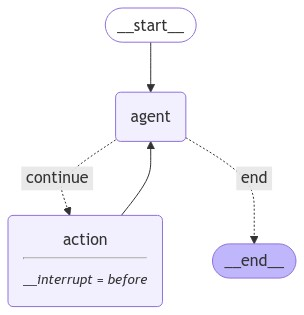

In [2]:
# Set up the tool
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
from langgraph.graph import MessagesState, START
from langgraph.prebuilt import ToolNode
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)

# Set up the model

model = ChatAnthropic(model="claude-3-5-sonnet-20240620")
model = model.bind_tools(tools)


# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Set up memory
memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable

# We add in `interrupt_before=["action"]`
# This will add a breakpoint before the `action` node is called
app = workflow.compile(checkpointer=memory, interrupt_before=["action"])

display(Image(app.get_graph().draw_mermaid_png()))

## Interacting with the Agent

We can now interact with the agent.

We see that it stops before calling a tool, because `interrupt_before` is set before the `action` node.

In [11]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": "3"}}
inputs = [HumanMessage(content="search for the weather in sf now")]
for event in app.stream({"messages": inputs}, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

search for the weather in sf now
================================== Ai Message ==================================

[{'text': "Certainly! I'll search for the current weather in San Francisco for you. Let me use the search function to find this information.", 'type': 'text'}, {'text': None, 'type': 'tool_use', 'id': 'toolu_011ezBx5hKKjVJwqnECNPyyC', 'name': 'search', 'input': {'query': 'current weather in San Francisco'}}]


**Resume**

We can now call the agent again with no inputs to continue.

This will run the tool as requested.

Running an interrupted graph with `None` in the inputs means to `proceed as if the interruption didn't occur.`

In [6]:
for event in app.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search

["It's sunny in San Francisco, but you better look out if you're a Gemini \ud83d\ude08."]
================================== Ai Message ==================================

Based on the search results, I can provide you with information about the current weather in San Francisco:

The weather in San Francisco right now is sunny. 

It's worth noting that the search result includes a playful reference to astrology, suggesting that Geminis should "look out." However, this is likely just a humorous addition and not related to the actual weather conditions.

Is there anything else you'd like to know about the weather in San Francisco or any other location?
